# Finding crop dates using MODIS

In [1]:
# Import logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.captureWarnings(True)

# Import libraries
import json
import calendar
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

# Import Descartes Labs' libraries
import descarteslabs as dl
import descarteslabs.workflows as wf

In [2]:
# Load the AOI geojson file
with open('mauritania.geojson') as json_file:
    aoi_json = json.load(json_file)

In [3]:
# Extract dltiles from the large AOI
resolution = 500  # meters
tilesize = 512
dltiles = dl.scenes.DLTile.from_shape(shape=aoi_json['features'][0]['geometry'],
                                        resolution=resolution,
                                        tilesize=tilesize,
                                        pad=0)
tile_keys = [x.key for x in dltiles]
ntiles = len(dltiles)
print('Number of tiles in AOI:', ntiles)

Number of tiles in AOI: 47


### Define "entry_function" which we may use to use Tasks (i.e. parallel compute)

In [69]:
def entry_function(tile_key):
    
    # Import libraries that will be called within the entry_function)
    import logging
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logging.captureWarnings(True)

    import numpy as np
    from datetime import datetime
    
    import descarteslabs as dl
    import descarteslabs.workflows as wf
    
    # Get dltile from tile key
    dltile = dl.scenes.DLTile.from_key(tile_key)
    
    # Define time periods
    year = 2010
    start_date = datetime(year, 1, 1, 0, 0, 0)
    end_date = datetime(year, 12, 31, 23, 59, 59)
    
    # Value used to define crops in the mask
    crop_value = 2
    
    # Get image collection of 16-day rolling composite of MODIS NDVI
    # Workflows make it easy to aggregate the data by date in case
    # there are more than one scene over the tile
    modis_ic = (wf.ImageCollection.from_id("modis:mod13q1:006", 
                                        start_datetime=start_date,
                                        end_datetime=end_date,
                                        resampler='lanczos')
                                 .groupby(dates=("year", "month","day")).sum(axis="images"))
    
    # Extract the NDVI variable
    modis_ndvi = modis_ic.pick_bands('ndvi')
    
    # Get numpy array for NDVI
    modis_data = modis_ndvi.compute(dltile)
    modis_array = modis_data.ndarray
    modis_array = modis_array[:,0]
    
    # Get the dates associated to each scene
    dates_ndvi = modis_ndvi.map(lambda img: img.properties["group"]).compute(dltile)
    
    # Number of time steps in NDVI array
    nt = len(dates_ndvi)
    print('Number of scenes for ' + str(year) + ':', nt)
    
    # Load 2015 crop mask using Scenes (can't use Workflows because this
    # product doesn't have an alpha/no data band)
    scenes_mask, ctx = dl.scenes.search(dltile,
                products="usgs:gfsad30:global",
                start_datetime="2014-01-01",
                end_datetime="2016-01-01")
    crop_mask = scenes_mask.mosaic('Land_Cover', ctx)
    crop_mask = crop_mask.astype(float)
    
    # Get the land cover types for the current tile
    land_cover_types = np.unique(crop_mask)
    
    # Continue if there are crops in this tile
    if crop_value in land_cover_types:
        
        # Repeat the crop mask nt times
        crop_mask_tiled = np.repeat(crop_mask, nt, axis=0)
        
        # Mask the NDVI array using the crop mask
        ndvi_masked = np.ma.masked_where(crop_mask_tiled != crop_value, modis_array)
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(crop_mask[0,:,:], vmin=0, vmax=crop_value)
        plt.colorbar()
        
        plt.subplot(1,2,2)
        plt.imshow(ndvi_masked[0,:,:], vmin=-1, vmax=1)
        plt.colorbar()
        
        plt.show()
        
        ## Up to here we have masked arrays of NDVI, only dislaying values over crop pixels ##
        ## Implement algorithm to pick the peak and harvest over the crop pixels ##
    
    return ndvi_masked


Job ID: a9dc83927c6566a48542befcdc1e10cd4228bb0d877c2984
[######] | Steps: 0/0 | Stage: DONE | Status: SUCCESS                         
Job ID: eff121a01e443106968cf97aedef212a56a7589357020823
[      ] | Steps: 0/0 | Stage: RUNNING | Status: SUCCESS                      23
[(2010, 1, 1), (2010, 1, 17), (2010, 2, 2), (2010, 2, 18), (2010, 3, 6), (2010, 3, 22), (2010, 4, 7), (2010, 4, 23), (2010, 5, 9), (2010, 5, 25), (2010, 6, 10), (2010, 6, 26), (2010, 7, 12), (2010, 7, 28), (2010, 8, 13), (2010, 8, 29), (2010, 9, 14), (2010, 9, 30), (2010, 10, 16), (2010, 11, 1), (2010, 11, 17), (2010, 12, 3), (2010, 12, 19)]
Number of scenes for 2010: 23


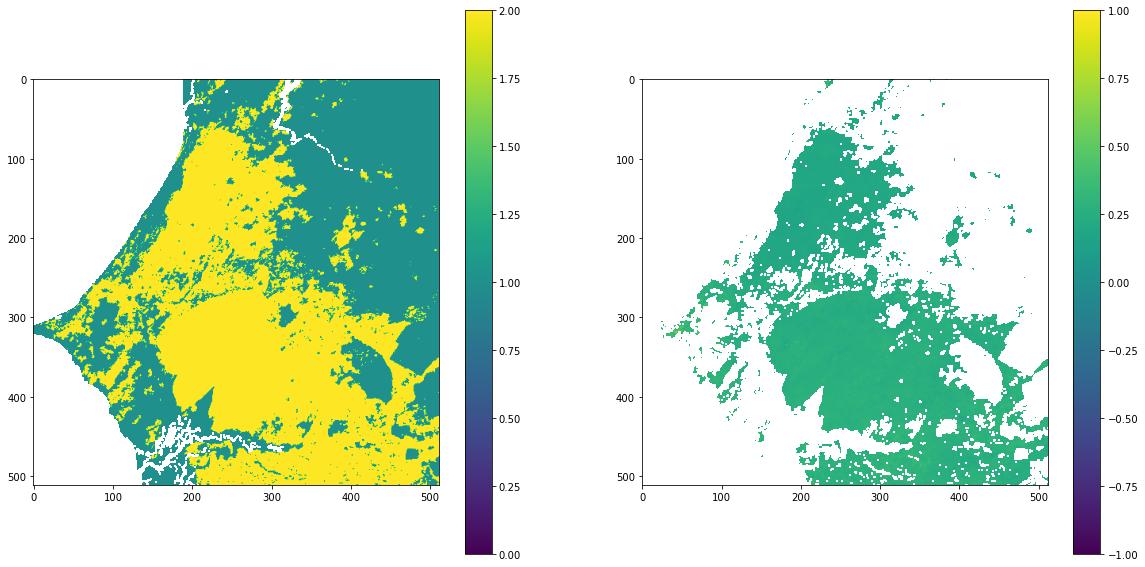

In [70]:
# Test the entry_function for the first tile
ndvi_masked = entry_function(tile_keys[0])

In [46]:
modis_array.shape

(23, 512, 512)